In [1]:
import torch
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from transformers import AutoTokenizer, GPT2LMHeadModel, GPTNeoXForCausalLM
from datasets import load_dataset
from transformer_lens import HookedTransformer, utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Disable gradient calculations
torch.set_grad_enabled(False)

In [4]:
hooked_model = HookedTransformer.from_pretrained("gpt2-xl", device='cuda:0')

Loaded pretrained model gpt2-xl into HookedTransformer


In [5]:
from datasets import load_dataset
dataset = load_dataset("EleutherAI/the_pile_deduplicated", split='train', streaming=True)

Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

In [6]:
# Define the set of punctuation characters to check
punctuation_chars = set("()[]{}.,;:!?-/\\\"'`~@#$%^&*_+=|<>")
letters = set("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")

amount=2000
# Initialize empty lists to aggregate words
prompts_ing = []
prompts_no_ing = []

# Iterate over the dataset
for prompt in tqdm(dataset.take(amount)):
    if len(prompts_ing)>=1000:
            break
    filtered_words = prompt['text'].split()
    
    # # Filter out words with unwanted characters using regex and check for all caps
    # filtered_words = [
    #     word for word in split
    #     if not re.search(r'[\n\d]', word) and
    #     not any(char in punctuation_chars for char in word) and
    #     not word.isupper() and
    #     word.lower() == word and all(char in letters for char in word)
    # ]
    
    for index in range(len(filtered_words)):
        
        sentence = filtered_words[index:index+24]
        sentence = " ".join(sentence)

        tokens = hooked_model.to_str_tokens(sentence, prepend_bos=False)
        # if 'ing' in tokens[-1]:
        #     print(tokens[-1])
        if tokens[-1] == 'ing':
            prompts_ing.append("".join(sentence))

    for index in range(0,len(filtered_words),24):
        if len(prompts_ing)>=1000:
            break
        sentence = filtered_words[index:index+24]
        tokens = hooked_model.to_str_tokens(sentence, prepend_bos=False)
        if tokens[-1] == 'ing':
            pass
        else:
            prompts_no_ing.append(" ".join(sentence))
        

print("Collected words ending with 'ing':", prompts_ing)
print("Collected words not ending with 'ing':", prompts_no_ing)


2000it [21:07,  1.58it/s]

Collected words ending with 'ing': ['fixing the crazy characters in it. My own stream was probably boring to watch since I was coding for the most time. But livestreaming', 'jOOQ uses a reverse engineering paradigm (as in mapping relational entities to objects > "ROM"). Re: jOOQ on The ORM Foundation? Object Role Modeling', 'original ORM) is not the same thing as Object/Relational Mapping. Object/Relational Mapping is still kind-of relevant and interesting to us, since Object Role Modeling', 'ORM". I actually came across your group because of your linking to ORM Lite (where ORM does stand for Object/Relational Mapping Object Role Modeling', 'is the entire point to Memristors and DARPAs SyNAPSE program, emulating Neurons.. So in the memristor, NVs (which are truly Ancillas), Return to "resting', 'to push! I knew as soon as I felt it. As the baby descended, I felt the burning sensation of the babies head crowning', 'my husband say “push, his body is stuck!” I ended up pushing as hard as 

In [7]:
print(len(prompts_ing), len(prompts_no_ing))
prompts_no_ing = random.sample(prompts_no_ing, 1000)
prompts_ing = random.sample(prompts_ing, 1000)
print(len(prompts_ing), len(prompts_no_ing))

1000 53270
1000 1000


In [67]:
@torch.no_grad()
def vector_moments(values, dim=1):
    mean = torch.mean(values, dim=dim)
    diffs = values - mean[:, None]
    var = torch.mean(torch.pow(diffs, 2.0), dim=dim)
    std = torch.pow(var, 0.5)
    zscore = diffs / std[:, None]
    skew = torch.mean(torch.pow(zscore, 3.0), dim=dim)
    kurt = torch.mean(torch.pow(zscore, 4.0), dim=dim)
    return mean, var, skew, kurt

@torch.no_grad()
def neuron_vocab_cosine_moments(model):
    # runs computation on whatever device model is loaded on (recommended to use mps if available)
    n_layers, d_mlp, d_vocab = model.W_out.shape[0], model.W_U.shape[1], model.W_out.shape[1]
    means, variances, skews, kurtoses = [], [], [], []

    W_U = model.W_U / model.W_U.norm(dim=0, keepdim=True)

    for i in range(n_layers):
        w_out = model.W_out[i]

        direct = w_out @ W_U
        direct = direct / w_out.norm(dim=1)[:, None]

        mean, var, skew, kurt = vector_moments(direct)

        means.append(mean)
        variances.append(var)
        skews.append(skew)
        kurtoses.append(kurt)

    # Flatten the list of numpy arrays.
    means = torch.stack(means).flatten().cpu().numpy()
    variances = torch.stack(variances, dim=0).flatten().cpu().numpy()
    skews = torch.stack(skews, dim=0).flatten().cpu().numpy()
    kurtoses = torch.stack(kurtoses, dim=0).flatten().cpu().numpy()

    n_layers, d_mlp, _ = model.W_out.shape

    neuron_moments_df = pd.DataFrame({
        'vocab_mean': means,
        'vocab_var': variances,
        'vocab_skew': skews,
        'vocab_kurt': kurtoses
    }, index=pd.MultiIndex.from_product([range(n_layers), range(d_mlp)]))
    neuron_moments_df.index.names = ['layer', 'neuron']

    return neuron_moments_df

data = neuron_vocab_cosine_moments(hooked_model)

kurtosis_threshold = 10

# Add columns to identify predictive and suppressive neurons
data['is_predictive'] = (data['vocab_kurt'] > kurtosis_threshold) & (data['vocab_skew'] > 0)
data['is_suppressive'] = (data['vocab_kurt'] > kurtosis_threshold) & (data['vocab_skew'] < 0)

# Group by layer and count predictive and suppressive neurons
layer_counts = data.groupby('layer').agg({
    'is_predictive': 'sum',
    'is_suppressive': 'sum'
}).reset_index()

# Calculate percentage of layers
total_layers = layer_counts['layer'].max()
layer_counts['layer_percentage'] = (layer_counts['layer'] / total_layers) * 100



In [68]:
cache_mlp_post_ing = []
is_ing = []
for input in tqdm(prompts_ing):
    pattern_filter = lambda name: any(name.endswith(f"hook_{s}") for s in ["post"])
    logs, cache = hooked_model.run_with_cache(input, names_filter=pattern_filter,remove_batch_dim=True, prepend_bos=True)
    tokens = hooked_model.to_str_tokens(input)
    is_ing.append(hooked_model.to_string(np.argmax(logs[:,-2,:].cpu(), axis=-1))=="ing")
    cache.to("cpu")
    vals_post = cache.stack_activation("post").detach().cpu().numpy()
    vals_post = vals_post[:,-2, :]
    cache_mlp_post_ing.append(vals_post)
    

cache_mlp_post_ing = np.array(cache_mlp_post_ing)


100%|██████████| 1000/1000 [01:15<00:00, 13.26it/s]


In [69]:
model_accuracy = np.mean(is_ing)
print(f"Model accuracy: {model_accuracy:.2f}")

Model accuracy: 0.77


In [70]:
cache_mlp_post_no_ing = []
for input in tqdm(prompts_no_ing):
    pattern_filter = lambda name: any(name.endswith(f"hook_{s}") for s in ["post"])
    logs, cache = hooked_model.run_with_cache(input, names_filter=pattern_filter,remove_batch_dim=True)
    tokens = hooked_model.to_str_tokens(input)
    cache.to("cpu")
    vals_post = cache.stack_activation("post").detach().cpu().numpy()
    vals_post = vals_post[:,-2, :]
    cache_mlp_post_no_ing.append(vals_post)

cache_mlp_post_no_ing = np.array(cache_mlp_post_no_ing)


100%|██████████| 1000/1000 [01:15<00:00, 13.30it/s]


In [71]:
# You can get these from the find_neuron notebook
important_neurons = np.array([(46, 4888),
 (47, 1678),
 (43, 1157),
 (36, 267),
 (39, 909),
 (36, 2973),
 (41, 2155),
 (44, 2890),
 (45, 1184),
 (30, 3370),
 (46, 5578),
 (33, 1484),
 (33, 143),
 (29, 2673),
 (33, 5111),
 (39, 2211),
 (42, 1434),
 (45, 588),
 (37, 3822),
 (44, 5139),
 (31, 5541),
 (33, 5101),
 (36, 3273),
 (33, 1689),
 (33, 2540),
 (41, 6359),
 (24, 3822),
 (41, 2219),
 (36, 1912),
 (45, 5128),
 (31, 2843),
 (34, 2122),])

In [74]:
# You can get these from the find_neuron notebook
is_pred = [False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True]

### Do logistic Regression

In [75]:
def format_subplot(ax, grid_x=True):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if grid_x:
        ax.grid(linestyle='--', alpha=0.4)
    else:
        ax.grid(axis='y', linestyle='--', alpha=0.4)

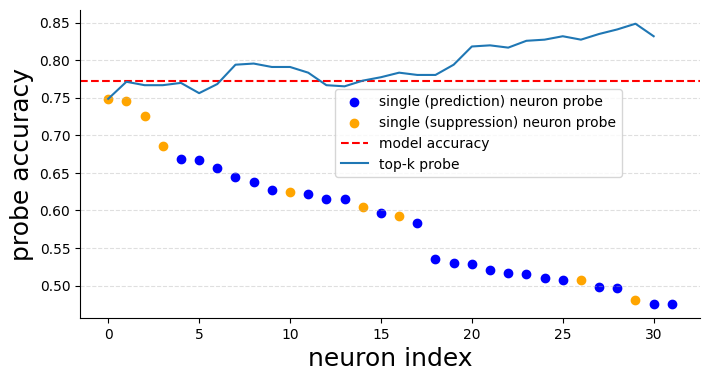

In [92]:
import numpy as np

plt.figure(figsize=(8, 4))
accuracy_single = []
dataset_size = len(prompts_ing)

for k in range(len(important_neurons)):
    important_neurons_top_k = important_neurons[k:k+1]

    # Correctly index into the values
    layers = important_neurons_top_k[:, 0]
    neurons = important_neurons_top_k[:, 1]
    sequence_indices = np.arange(cache_mlp_post_ing.shape[0])[:, None]

    # Indexing into cache_mlp_post_ing
    indexed_values_ing = cache_mlp_post_ing[:, layers, neurons]
    indexed_values_no_ing = cache_mlp_post_no_ing[:, layers, neurons]

    new_dataset = np.concatenate([indexed_values_ing, indexed_values_no_ing], axis=0)
    # Train a logistic regression model to predict whether a word ends with 'ing' or not with top k neurons

    X_train, X_test, y_train, y_test = train_test_split(new_dataset, [1] * dataset_size + [0] * dataset_size, test_size=0.33, random_state=42)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracy_single.append(accuracy_score(y_test, y_pred))

# Sorting accuracies and applying masks
sorted_indices = np.argsort(accuracy_single)[::-1]
sorted_accuracy_single = np.array(accuracy_single)[sorted_indices]
sorted_is_pred = np.array(is_pred)[sorted_indices]

mask_0 = sorted_is_pred == True
mask_1 = sorted_is_pred == False

plt.scatter(np.where(mask_0)[0], sorted_accuracy_single[mask_0], label='single (prediction) neuron probe', color='blue')
plt.scatter(np.where(mask_1)[0], sorted_accuracy_single[mask_1], label='single (suppression) neuron probe', color='orange')

# Sort important neurons by accuracy 
important_neurons = important_neurons[sorted_indices]

accuracy = []

for k in range(1, len(important_neurons)):
    important_neurons_top_k = important_neurons[:k]

    # Correctly index into the values
    layers = important_neurons_top_k[:, 0]
    neurons = important_neurons_top_k[:, 1]
    sequence_indices = np.arange(cache_mlp_post_ing.shape[0])[:, None]

    # Indexing into cache_mlp_post_ing
    indexed_values_ing = cache_mlp_post_ing[:, layers, neurons]
    indexed_values_no_ing = cache_mlp_post_no_ing[:, layers, neurons]

    new_dataset = np.concatenate([indexed_values_ing, indexed_values_no_ing], axis=0)
    # Train a logistic regression model to predict whether a word ends with 'ing' or not with top k neurons

    X_train, X_test, y_train, y_test = train_test_split(new_dataset, [1] * dataset_size + [0] * dataset_size, test_size=0.33, random_state=42)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))

# Plot accuracy vs number of neurons
# set fig size 

plt.axhline(y=model_accuracy, color='r', linestyle='--', label='model accuracy')
plt.plot(range(0, len(important_neurons)-1), accuracy, label='top-k probe')
plt.xlabel('neuron index', fontsize=18)
plt.ylabel('probe accuracy', fontsize=18)
#place legend right
plt.legend(loc='center left', bbox_to_anchor=(0.4, 0.6))
format_subplot(plt.gca(), grid_x=False)
#save pdf 

plt.savefig('probe_accuracy.pdf', bbox_inches='tight')
plt.show()
